# Setup

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

import ipywidgets as widgets

# modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from utils import plot_acf_pacf, adf_test, kpss_test
from utils import metrics


# path handling
from pathlib import Path
from utils import load_last_final_data

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 

<AxesSubplot:xlabel='Date'>

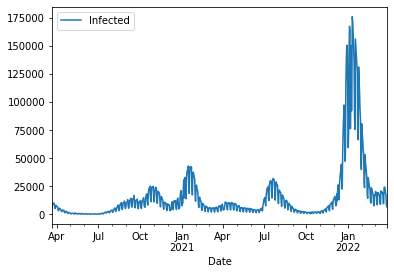

In [2]:
df = load_last_final_data(from_folder='processed')
df = df[['Infected']][20:]
df.plot()

**Interpretation of the line plot**

From the above graph, it can be concluded that:
1. The data show positive and strong autocorrelation.
2. Apparently, there is no significant trend. 
3. Seasonal patterns are found each 7 days (weekly).

For the analysis to make sense, the data are divided into two subsets: train and test data. The necessary properties will be extracted from the train set and the model will be fitted with them. Test data will be used to make forecasts and evaluate the adjusted model. 

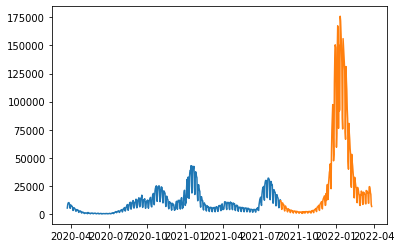

In [3]:
train, test = train_test_split(df, test_size=0.3)
plt.plot(train)
plt.plot(test)

# ARIMA
The first stage is model identification or obtaning initial guesses for the ARIMA parameters $p, d, q$. Identification is a necessarily inexact procedure, where graphical methods are of particular interest. Preliminary identification comes together with estimation to provide a first class of models to be fitted and diagnosed.

The objective is to identify a suitable subclass of models from the general ARIMA models family, formally expressed as:
$
\begin{equation}
\phi(B) \nabla^{d} z_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
The time series could then be described by this model.

For this purpose, the following approach is used:
1. Produce stationarity by differencing the series $z_t$ as many times as necessary. This would reduce the underlying process to the mixed autorregressive-moving average process:
$
\begin{equation}
\phi(B) w_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
where $w_t=(1-B)^{d}z_t = \nabla^{d}z_t$.
2. Identify the ARMA process.

Autocorrelation and partial autocorrelation functions (and plots) will shed light on which initial parameters to take.

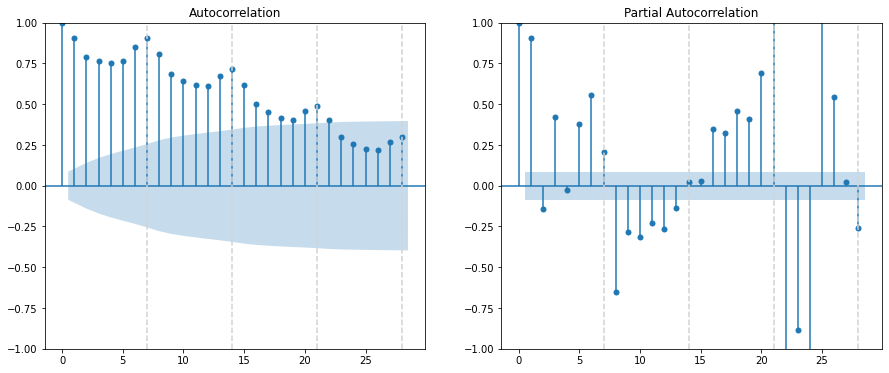

In [4]:
plot_acf_pacf(train)

**Interpretation of the autocorrelation plot**

The autocorrelation plot above shows that:
1. The sample autocorrelations are very strong and positive.
2. The sample autocorrelations decay slowly with lags.
3. Peaks are seen in the multiplies of 7, indicating seasonality.

<!-- The standard error at a lag $k$ is found under the assumption that
right model is an MA(k-1). This allows the possible interpretation: if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. -->

Failure of the estimated autocorrelation function to die out rapidly suggests that the underlying stochastic process might be treated as nonstationary in $z_t$ but possibly as stationary in $\nabla z_t$.

From the above, it follows that a certain degree of differentiation $d$ is needed to achieve stationarity. The nonstationary series will have been transformed into a stationary one when the autocorrelation function of $w_t=\nabla^{d}z_t$ for some $d$ (usually $d=1$ or $d=2$) dies out quickly.

## Stationarity

In order to adjust a statistical model, we must ensure first that the timeseries is stationary. Stationarity means that the statistical properties such as mean, variance and covariance of a timeseries do not change over time. Equivalently: the properties of the series do not depend on the instant of time (time-invariant).

It the timeseries is not stationary, its properties can vary with time. Thus, the properties used at time $t$ to make a prediction at $t+k$ may be different from those observed in that prediction and therefore inaccurate.

### Tests for checking stationarity

To check the stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Augmented Dickey Fuller (ADF) test: this test is used determine whether a unit root exists in a series, and thus helps to understand whether the series is stationary. 
    - Null Hypothesis: The series has a unit root (timeseries is **not** stationary).
    - Alternate Hypothesis: The series has no unit root (timeseries is stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then the null hypothesis is rejected and infers that timeseries is stationary. If p-value>$\alpha$, the timeseries is not stationary and a differentiation order must be found.

2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: another test to check the stationarity of time series. The hypothesis for this test are opposite that of the ADF test.
    - Null Hypothesis: The process is trend stationary.
    - Alternate Hypothesis: The series has a unit root (series is not stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then timeseries is not stationary. If p-value>$\alpha$, the timeseries is stationary and a differentiation order must be found.

Results must be interpreted as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


### Tests for checking seasonal stationarity
To check the seasonal stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Osborn-Chu-Smith-Birchenhall (OCSB) test: test for seasonal unit root roots in a time series. Determines whether it needs seasonal differencing. The hypothesis are:
    - Null Hypothesis: the series contains a seasonal unit root (timeseries is not seaonal stationary).
    - Alternate Hypothesis: the series does not contain a seasonal unit root (timeseries is seasonal stationary).

2. Canova-Hansen (CH) test: test for seasonal differences. 
    - Null Hypothesis: the seasonal pattern is stable over time
    - Alternate Hypothesis: the seasonal pattern is unstable over time

In [5]:
# test stationarity on the original series
print('Stationarity tests on the original series:')
adf_test(train,  print_only_result=False)
kpss_test(train, print_only_result=False)

Stationarity tests on the original series:

ADF Test Results
-----------------
ADF Statistic: -2.942205375285237
p-value: 0.04065562800924611
num lags: 19
Critical Values:
	1% : -3.4436298692815304
	5% : -2.867396599893435
	10% : -2.5698893429241916
Result: The timeseries is stationary

KPSS Test Results
-----------------
KPSS Statistic: 0.7081027580358807
p-value: 0.012808840178556295
num lags: 15
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is not stationary


ADF test indicates stationarity but KPSS does not: the series is difference stationarity. The series with the first difference is studied now.

In [6]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(train)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(train)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


The series does not require a seasonal difference.

### Differenced series

The plot below shows the differenced series for $d=1$. 

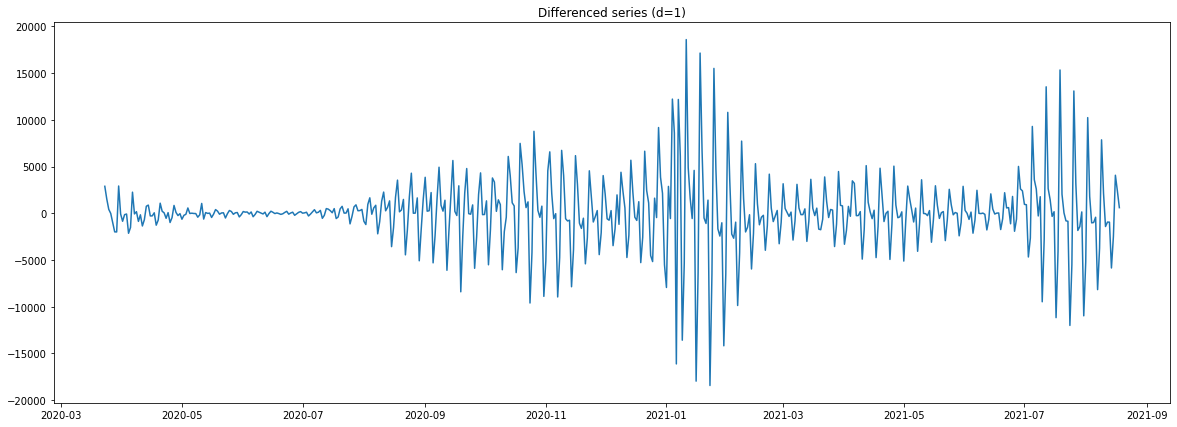

In [7]:
# take one difference (d=1)
df_d1 = train.diff().dropna()
# plot the differenced series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced series (d=1)')
plt.plot(df_d1)

**Interpretation of the differenced series**

The differenced series vary around zero (constant mean) now. However, it can be observed that the series fluctuates around this zero mean with a variable variance. Therefore, a logarithm transform of the observations has to be applied to stabilize the variance.

### Log transform

From the line graph of the initial series it can also be deduced that it is necessary to apply a transformation to the data. Since the seasonal effect appears to be multiplicative, a logarithmic transformation is recommended to make the seasonal effect additive (constant from period to period). However, it is important to take into account that this transformation will only stabilize the variance if the error term is also multiplicative. 

**Note:** This transformation has to be applied on the original series and then take the first difference on it; it would be absurd to apply the log transformation to the previous differenced series since it has zero values.

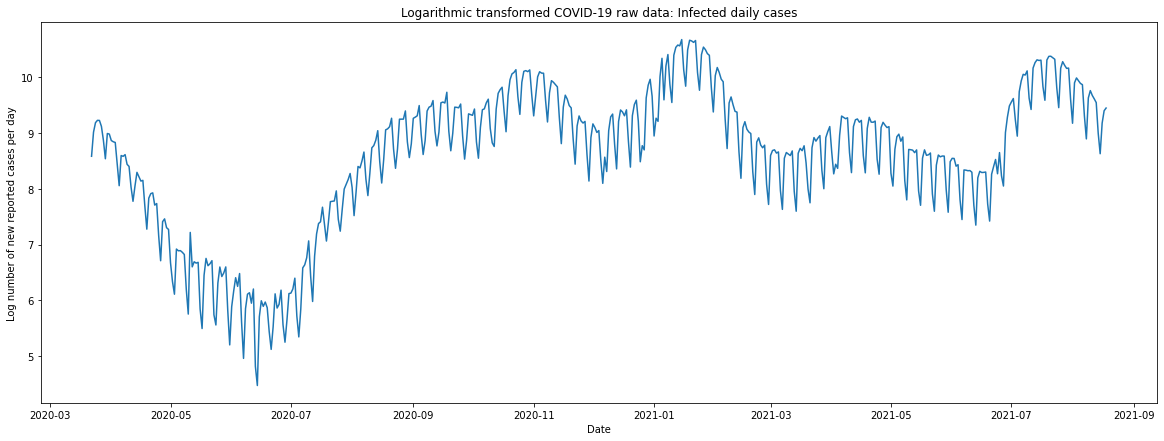

In [8]:
# apply a log transformation to the original data (having ensured that there is no zero value)
log_series = np.log(train)

# plot log-transformed data to confirm that the seasonal effect is now additive
fig = plt.figure(figsize=(20, 7))
plt.plot(log_series)
plt.xlabel('Date')
plt.ylabel('Log number of new reported cases per day')
plt.title('Logarithmic transformed COVID-19 raw data: Infected daily cases')
plt.show()

The log transformation appears to have been reasonable: the seasonal fluctuations are preserved but now they are in an additive fashion. 

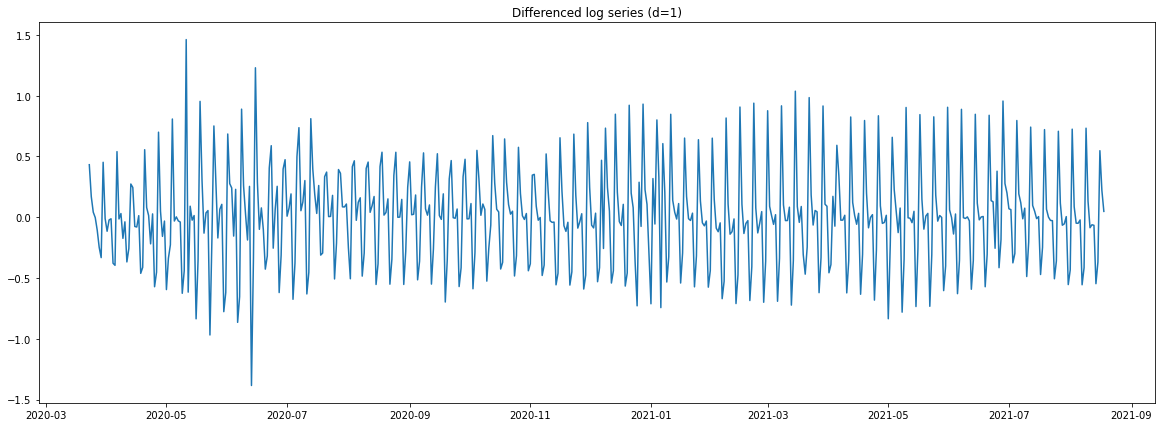

In [9]:
# difference the log series
df_d1 = log_series.diff().dropna()

# plot the resulting series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=1)')
plt.plot(df_d1)

The graph above shows a more stationary version of the series is obtained: constant mean around zero, constant variance around the mean.

The next step now is to examine the ACF and PACF plots for the differenced series:

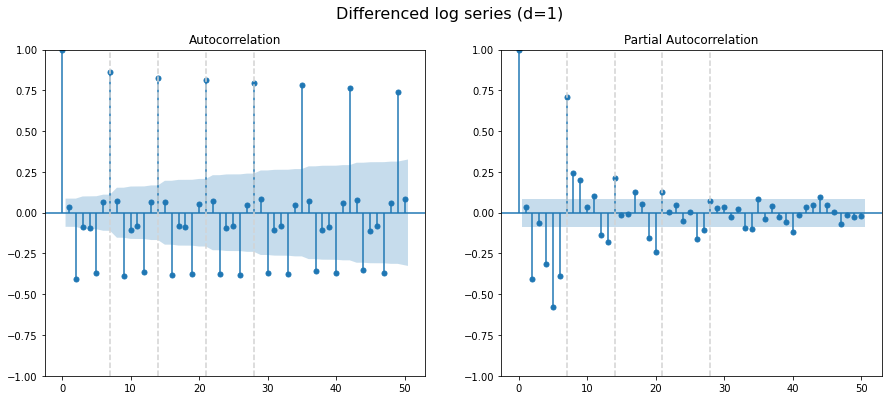

In [10]:
plot_acf_pacf(df_d1, 'Differenced log series (d=1)', lags=50)

The ACF shows constant peaks in the coefficients of 7, 14, ... lags, indicating the presence of a significant 7 period seasonal component. These seasonal components in the ACF remain constant with lag increase; in the PACF they tend to decay towards zero. The series does not exhibit stable seasonal behaviuor (oscillations), so there would be no need to take seasonal differences.

### Check stationarity of transformed series

Finally, the stationarity (regular and seasonal) of the transformed series should be checked. 

In [11]:
# test stationarity on the transformed series
print('Stationarity tests on the transformed series:')
adf_test(df_d1)
kpss_test(df_d1)

Stationarity tests on the transformed series:

ADF Test Results
-----------------
Result: The timeseries is stationary

KPSS Test Results
-----------------
Result: The timeseries is stationary


In [12]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(df_d1)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(df_d1)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


When testing stationarity, the tests concludes that this series is stationary and seasonal stationary for both OCSB and CH tests.

# Estimation of ARIMA models

Once the stationarity parameters (d, D) has been derived, a preliminary type of model should be provided and then the residuals must be studied to add to the previous model the structure that it was missing. 

Equivalently, the process of seeking the best order of parameters can be performed automatically. Given an information criterion (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively), different combinations of parameter orders are tested in order to minimize the value obtained with the criterion. This is the approach to be used. 

**Note:** It should be noted that, although there are functions capable of finding the optimal order of the parameters, it is not advisable to use them without previously knowing d and D. This is because the operation of differentiating converts one data series into a different one. Therefore, likelihood is calculated on two different series and, consequently, the values of the information criterion (commonly AIC or BIC) between models that have different orders of differencing cannot be compared. 
In definitive, this method is only recommended to find the order of p, q, P, Q.

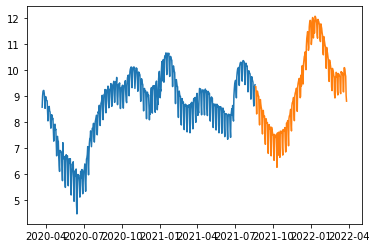

In [13]:
log_df = np.log(df)
train, test = train_test_split(log_df, test_size=0.3)
plt.plot(train)
plt.plot(test)

In [14]:
# Fit your model
model = pm.auto_arima(np.array(train), 
                    seasonal=True, 
                    m=7, 
                    d=1, 
                    D=0, 
                    error_action='ignore', 
                    parallelized=True)

In [15]:
model_parameters = model.get_params()
order = model_parameters['order']
seasonal_order = model_parameters['seasonal_order']

print('Best estimated order: \n\t (p, d, q) =', order)
print('Best estimated seasonal order: \n\t (P, D, Q, m) =', seasonal_order)

Best estimated order: 
	 (p, d, q) = (2, 1, 1)
Best estimated seasonal order: 
	 (P, D, Q, m) = (2, 0, 1, 7)


### Model Diagnostic Checking

Residuals are defined as the difference between the observations and the fitted values. They are indispensable to check whether a model captures all information in the data correctly. Visual inspection of a plot of the residuals themselves is an essential first step in the checking process. A forecasting method would be considered adequate if the resulting residuals verify the next properties:

1. Uncorrelation: If the residuals are autocorrelated, then the residuals still contain information left that should be added to the model.
2. Zero mean: Residuals with a mean other than zero indicate bias in forecasts.

If either of these properties is not satisfied, then the model can be modified to provide better forecasts. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method. 


In addition to the properties above, it is convenient (although not necessary) for the residuals to also have the following properties:

3. Homocedasticity (i.e, constant variance)
4. Normal distribution

However, a forecasting method that does not satisfy these properties cannot necessarily be improved. These additional properties are important in the calculation of prediction intervals.


#### ARIMA Results

The following tests and concepts will be used to ensure and verify the above.

- Ljung-Box Test: tests whether the errores are white noise by checking if the autocorrelations of the residuals are zero. It can be thought as a test of lack of fit: if the sample autocorrelations of residuals are close to zero, there is no missing structure to be added to the model and therefore it does not show significant lack of fit.
    - $H_0$: The residuals are independently distributed (autocorrelations in the population from which the sample is taken are zero; any observed aucorrelation in the residuals result from randomness of the sampling process). (the model is correctly fitted)
    - $H_1$: The residuals are not independently distributed (exhibit serial correlation).
    - A significant $p-$ value (<0.05) rejects $H_0$ that the autocorrelations are zero; $p-$ value>0.05 is sought in order not to reject $H_0$.


- Heteroskedasticity Test: test fot heteroskedasticity of standarized residuals; tests whether residuals are homocedastic (they have the same variance).
    - $H_0$: No heteroskedasticity.
    - $H_1$: Heteroskedasticity.
    - A significant $p-$ value rejects $H_0$ that the residuals are not heteroskedastic; $p-$ value>0.05 is preferred in order not to reject $H_0$.
    

- Jarque-Bera Test: test for normality of standarized residuals. As part of this test, skew and kurtosis are also computed. 
    - $H_0$: Normality.
    - $H_1$: No normality; residuals follow another distribution.
    - A significant $p-$ value rejects $H_0$ that the residuals are normally distributed; $p-$ value>0.05 is preferred in order not to reject $H_0$.


The stage of selecting the best model involves some probabilistic criteria, capable of measure model performance and model complexity on the training set. The actual value of the measure for a model is irrelevant on its own; the purpose of these criteria is the comparison of models. The following are displayed in the next analysis:
- Log likelihood: this function identifies the distribution that fits best the training data. The higher the value of the log-likelihood, the better a model fits a dataset. The log-likelihood value obtained can range from negative infinity to positive infinity. Adding predictor variables to a model will increase the log-likelihood value even if the additional predictor variables aren’t statistically significant, leading to overfitting.
- AIC (Akaike Information Criterion): Estimates the amount of information lost by a given model: the less information the model loses, the higher the quality of the model. AIC addresses the trade-off between model goodness of fit and model simplicity. In other words, AIC addresses the risk of overfitting and the risk of underfitting.
- BIC: Lower BIC models are usually preferred. It is partly based on probability functions and is closely related to the AIC. When fitting the model, the likelihood can be increased by adding parameters, but this can lead to overfitting. Both BIC and AIC attempt to address this problem by introducing a penalty term for the number of parameters in the model; BIC has a larger penalty term than AIC.
- HQIC: As in AIC, HQC introduces a penalty term for the number of parameters in the model, but the penalty is greater than one in AIC. The model with the lower HQC value is preferred; a lower HQC implies a smaller number of explanatory variables, better fit, or both. In practice, it seems to have seen little use.

In [16]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  515
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood                 185.123
Date:                           Sun, 17 Jul 2022   AIC                           -356.246
Time:                                   22:01:59   BIC                           -326.551
Sample:                                        0   HQIC                          -344.608
                                           - 515                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0049      0.116      0.042      0.966      -0.222       0.232
ar.L2         -0.1783      0.046     -3.890

#### Interpretation of model results
 
Residuals diagnostic:

- Ljung-Box (L1) (Q) is the Ljung-Box test at lag 1. The value of the statistic is 0.00 and the $p$ -value is 0.97>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are white noise.
- Heteroskedasticity (H). The test statistic is 0.50 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are heteroskedastic.
- Jarque-Bera (JB) statistic is 484.72 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are not normally distributed. In addition, the residuals have a slight negative skew and a pretty large kurtosis.

<!-- https://robjhyndman.com/hyndsight/tests2/ (why not to use significance to choose variables in arima) -->

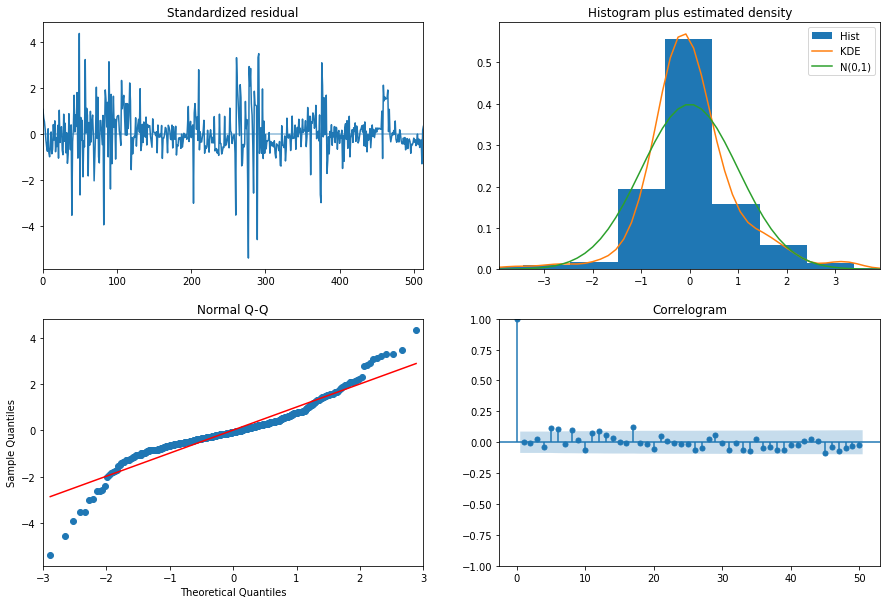

In [17]:
# graphic diagnostic
model.plot_diagnostics(figsize=(15,10), lags=50)
plt.show()

**Interpretation of the diagnostics graphs**

- The standarized residuals seem to have **zero mean** and have a shape similar to the white noise. It can also be deduced that the **variance is not constant** over time.
- The histogram and density plot show how the residuals **differ from a normal distribution**. It can be seen the slight **negative skew and a positive excess of kurtosis**.
- The Q-Q plot can help to asses if the residuals came from a theoretical normal distribution. If both sample-theoretical sets of quantiles came from the same distribution, the points should form a diagonal straight line. In this case, the Q-Q plot shows a distribution with **heavy tails** (as confirmed by the kurtosis above) vs. the normal distribution: most points are clustered on a line in the center of the plot, and some points curve (due to slight negative) and move away from the line in the extremities (due to slight negative skew and kurtosis). This means that the residuals have more extreme values or **outliers** relative to a normal distribution. <!-- https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html -->
- The correlogram help in identifying the residuals randomness. The standard errors for confidence intervals are determined under the hypothesis that the residuals are white noise. Since they are close to zero and almost none exceed the confidence intervals, the **residuals are white noise**.

#### Conclusion

The best model found is SARIMA(2, 1, 1)x(2, 0, 1, 7), this is:
- AR(2): the current value of the series $z_t$ depends on the previous two values $z_{t-1}, z_{t-2}$ of the series adjusted by some parameters (plus a constant term and a white noise value $\varepsilon_t$). 
- d=1: the series has no constant properties, so a difference is necessary.
- MA(1): the current value of the series $z_t$ depends on the adjusted previous white noise term $\varepsilon_{t-1}$ (plus a constant term and the current white noise term $\varepsilon_{t}$).
- The seasonal part has the same behaviour in ARMA process, but $D=1$. 

The residuals diagnostic concludes that the model captures all the non random patterns in data. 

# Forecasting

Having studied the properties of the SARIMA model that best describes the series, it is now shown how to use this model to forecast future values of an observed time series. The final objective here is to quantify the errors made by the model in predicting 14 future instants.

In [23]:
class SARIMA:

    def __init__(self, data, steps_ahead=14, order=(2, 1, 1), seasonal_order=(2, 0, 1, 7), metrics=metrics):
        self.steps_ahead = steps_ahead
        self.order = order
        self.seasonal_order = seasonal_order
        self.metrics = metrics

        # store data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data)

        self.model = self.fit_model()

        self.all_forecasts = None
        self.all_forecasts_ci = None
        self.baseline = None
    
    def train_test_split(self, data=None, test_size=0.3):
        """
        Split data into training and test sets
        Args:
            data: data to be split
        Returns:
            train: training data
            test: test data
        """
        if data is None:
            data = self.data
        train, test = train_test_split(data, test_size=test_size)
        return np.array(train).ravel(), np.array(test).ravel()

    def random_windows(self):
        """
        Generate random windows
        """
        # divide test in sliding windows
        test_windows = np.lib.stride_tricks.sliding_window_view(np.array(self.test).ravel(), self.steps_ahead)
        # take random index
        random_index = np.random.randint(0, test_windows.shape[0]-1)
        # history to train the model up to random_index
        history = np.append(self.train, self.test[:random_index]).ravel()
        model = self.fit_model(history)
        predicted_mean, predicted_ci = self.predict(model=model, return_ci=True)
    
        return history, test_windows[random_index], predicted_mean, predicted_ci

    def plot_windows(self, max_subplots=3):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        example_windows = [self.random_windows() for _ in range(max_subplots)]

        for history, test_window, predicted_mean, predicted_ci in example_windows:
            t_window = np.arange(self.steps_ahead+self.steps_ahead)
            history_window = history[-self.steps_ahead:]

            plt.figure(figsize=(8, 5))
            #plot historical Infected
            plt.plot(t_window[:self.steps_ahead+1], np.append(history_window, test_window[0]), color='dodgerblue', label='I real')
            #plot predicted mean Infected
            plt.plot(t_window[self.steps_ahead:], predicted_mean, color='darkorange', label='I predicted', marker='o')
            #plot predicted confidence interval
            plt.fill_between(t_window[self.steps_ahead:], predicted_ci[:,0], predicted_ci[:,1], color='darkorange', alpha=0.2)
            # plot I test
            plt.plot(t_window[self.steps_ahead:], test_window, color='blue', label='I test', marker='o')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()

    def get_best_SARIMA_model(self, print_summary=False, print_best_orders=True):
        """Automatically find the best SARIMA model for the given data"""
        model = pm.auto_arima(np.array(train), 
                    seasonal=True, 
                    m=7, # seasonality period
                    d=1, # difference necessary to achieve stationarity
                    D=0, # difference necessary to achieve seasonal stationarity
                    error_action='ignore', 
                    parallelized=True)

        # get the model parameters
        model_parameters = model.get_params()
        # get the best order and seasonal order
        best_order = model_parameters['order']
        best_seasonal_order = model_parameters['seasonal_order']
        if print_best_orders:
            print('Best estimated order: \n\t (p, d, q) =', best_order)
            print('Best estimated seasonal order: \n\t (P, D, Q, m) =', best_seasonal_order)
        if print_summary:
            print(model.summary())
        return model

    def fit_model(self, train_data=None):
        """Fit the model"""
        if train_data is None:
            train_data = self.train
        model = SARIMAX(train_data, order=self.order, seasonal_order=self.seasonal_order).fit()
        return model

    def predict(self, model=None, steps_ahead=None, return_ci=True):
        """
        Predict the future values of the time series
        Args:
            model: model to be used for prediction
            steps_ahead: number of steps ahead to predict
        Returns:
            predicted: predicted values
        """
        if model is None:
            model = self.model
        if steps_ahead is None:
            steps_ahead = self.steps_ahead
        forecast = model.get_forecast(steps=steps_ahead)
        predicted_mean = forecast.predicted_mean
        if return_ci:
            predicted_ci = forecast.conf_int()
            return predicted_mean, predicted_ci
        else:
            return predicted_mean

    def _evaluate(self, y_true, y_forecasted):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate
        for metric_name, metric in self.metrics.items():
            try:
                evaluation[metric_name] = metric(y_true, y_forecasted)
                # baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
            except:
                evaluation[metric_name] = np.nan
                # baseline_step_evaluation[metric_name] = np.nan
        return evaluation

    def predict_windows(self, steps_ahead=None, verbose=False):

        if steps_ahead is None:
            steps_ahead = self.steps_ahead
        
        forecasts = []
        forecasts_ci = []
        baseline = []

        history = self.train
        
        # walk-forward validation
        for t in range(len(self.test)-(steps_ahead-1)):
            # train model up to the final available time point
            model = self.fit_model(history)
            # make prediction
            predicted, predicted_ci = self.predict(model, steps_ahead=steps_ahead, return_ci=True)
            # store the prediction
            forecasts.append(predicted)
            forecasts_ci.append(predicted_ci)
            baseline.append(history[-1])
            # update the history
            history = np.append(history, self.test[t])

            if verbose:
                print(f'Observed: {self.test[t]}, Predicted: {predicted[steps_ahead-1]}, CI: {predicted_ci[steps_ahead-1]}')

            self.all_forecasts = np.array(forecasts)
            self.all_forecasts_ci =  np.array(forecasts_ci)
            self.baseline = np.array(baseline)
        return self.all_forecasts, self.all_forecasts_ci, self.baseline

    def evaluate(self, forecasts=None, baseline=None, steps_ahead=None):
        evaluation = {}
        if (forecasts is None) and (baseline is None):
            forecasts, _, baseline = self.predict_windows(steps_ahead=steps_ahead)
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # evaluate the model in the step 
        forecasts = forecasts[:, (steps_ahead-1)].ravel()
        test_windows = np.lib.stride_tricks.sliding_window_view(np.array(self.test).ravel(), steps_ahead)
        test = test_windows[:, (steps_ahead-1)].ravel()

        evaluation[f'step_{steps_ahead}'] = self._evaluate(np.exp(test), np.exp(forecasts))
        evaluation[f'baseline_step_{steps_ahead}'] = self._evaluate(np.exp(test), np.exp(np.array(baseline).ravel()))
        return evaluation

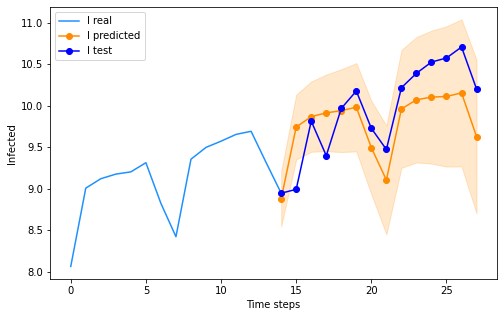

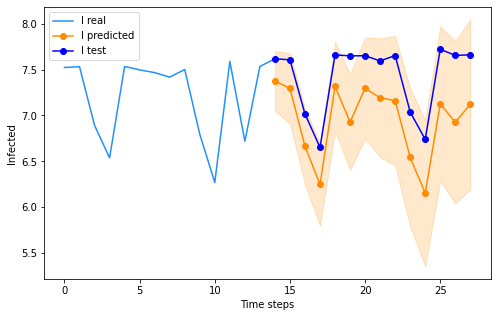

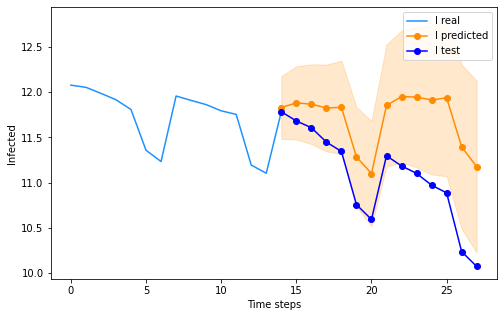

In [25]:
# forecasting
sarima = SARIMA(log_df)
forecasts, forecasts_ci, baseline = sarima.predict_windows(verbose=False)
sarima.plot_windows()

# Evaluation

#TODO: describir métricas y evaluación; definir qué es "largo plazo"

In [26]:
evaluation = sarima.evaluate()
pd.DataFrame(evaluation).style.highlight_min(axis=1)

,step_14,baseline_step_14
RMSLE,0.616371,0.702284
MAE,21309.013463,18010.451923
RMSE,41334.312501,31362.235888
MAPE,0.543484,0.605619


It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast (por el momento). #TODO: ampliar a estudio a largo plazo también.

## Forecasts residuals diagnostic

The study of the residuals corresponding to the 14-day forecasts shows that the conditions and properties of the series have changed. The line plot of residuals is far from that of white noise, so the series contains non-random structures that are not captured by the model. Seasonal patterns that have not been picked up by the fitted model appear, in addition to some AR(1) terms as shown in PACF plot. In addition, the distribution of residuals has heavy tails.

In [29]:
residuals = np.exp(sarima.all_forecasts[:, -1])-np.exp(sarima.test[13:])

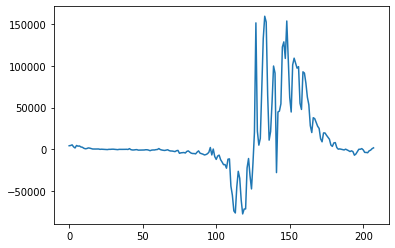

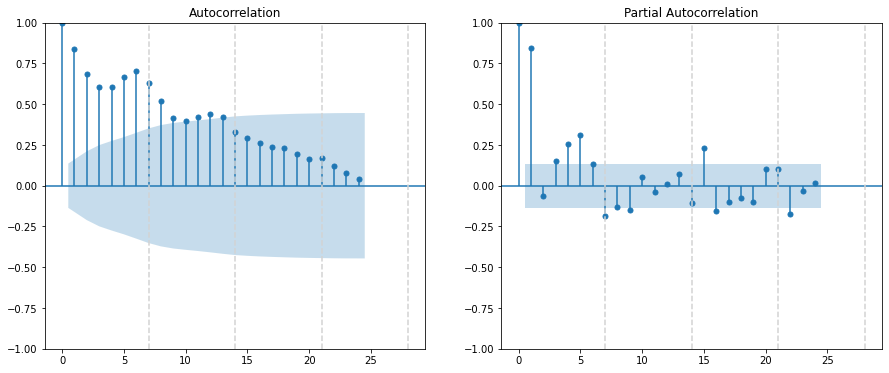

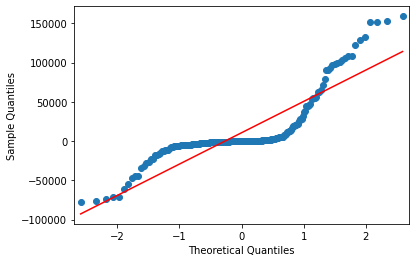

<AxesSubplot:ylabel='Density'>

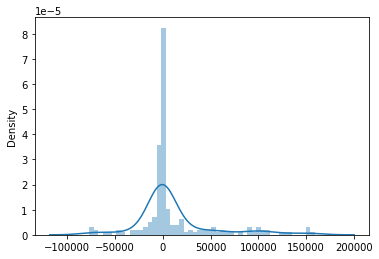

In [30]:
from statsmodels.graphics.gofplots import qqplot
plt.plot(residuals)
plt.show()
plot_acf_pacf(residuals)
plt.show()
plt.show()
qqplot(residuals, line='s')
plt.show()
sns.distplot(residuals)
